# Part1 CornerDetector
Author: Victor Badenas Crespo

## Purpose
Case study of the different effects of different corner detectors.

## Methodology
Modifying the example in [the scikit-image corner detection example](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_corner.html#sphx-glr-auto-examples-features-detection-plot-corner-py), the [corner detectors in the scikit image package](https://scikit-image.org/docs/stable/api/skimage.feature.html) are tested. 

Images from the [general purpose images of scikit-image](https://scikit-image.org/docs/stable/auto_examples/data/plot_general.html) will be used to evaluate and explain the advantages and disadvantages of those corner detectors.

***
## Setup

### Library import
We import all the required Python libraries

In [1]:
from matplotlib import pyplot as plt
import skimage

from skimage import data, color, io

from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, AffineTransform
from skimage.draw import ellipse
from pprint import pprint
import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

### Local library import and functions
We import all the required local libraries and user defined functions and utilities

In [2]:
def plotImages(images, grid=(2, 2), figsize=(15, 9), **kwargs):
    f, ax = plt.subplots(grid[0], grid[1], figsize=figsize)
    for imageIdx, (title, image) in enumerate(images.items()):
        cmap = plt.cm.gray if image.ndim == 2 else None
        if grid[0] == 1:
            ax[imageIdx].set_title(title)
            ax[imageIdx].imshow(image, cmap=cmap, **kwargs)
            ax[imageIdx].axis('off')
        else:
            ax[imageIdx//grid[1]][imageIdx%grid[1]].set_title(title)
            ax[imageIdx//grid[1]][imageIdx%grid[1]].imshow(image, cmap=cmap, **kwargs)
            ax[imageIdx//grid[1]][imageIdx%grid[1]].axis('off')
    return f, ax

In [ ]:
def bresenham_circle(c=[0,0], r=3):
    "Bresenham complete circle algorithm in Python"
    # init vars
    switch = 3 - (2 * r)
    points = list()
    x = 0
    y = r
    # first quarter/octant starts clockwise at 12 o'clock
    while x <= y:
        # first quarter first octant
        points.append((x,-y))
        # first quarter 2nd octant
        points.append((y,-x))
        # second quarter 3rd octant
        points.append((y,x))
        # second quarter 4.octant
        points.append((x,y))
        # third quarter 5.octant
        points.append((-x,y))        
        # third quarter 6.octant
        points.append((-y,x))
        # fourth quarter 7.octant
        points.append((-y,-x))
        # fourth quarter 8.octant
        points.append((-x,-y))
        if switch < 0:
            switch = switch + (4 * x) + 6
        else:
            switch = switch + (4 * (x - y)) + 10
            y = y - 1
        x = x + 1
    points = np.unique(points, axis=0) + np.array(c)
    return points

***
## Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [3]:
# skimage data image list
images = {
    'astronaut': None,
    'binary_blobs': None,
    'brick': None,
    'colorwheel': None,
    'camera': None,
    'cat': None,
    'checkerboard': None,
    'clock': None,
    'coffee': None,
    'coins': None,
    'eagle': None,
    'grass': None,
    'gravel': None,
    'horse': None,
    'page': None,
    'text': None,
    'rocket': None
}


In [4]:
# corner extraction method's functions
methods = {
    "fast": skimage.feature.corner_fast,
    "harris": skimage.feature.corner_harris
}

***
## Data import
We retrieve all the required data for the analysis.

In [5]:
# Sheared checkerboard
tform = AffineTransform(scale=(1.3, 1.1), rotation=1, shear=0.7,
                        translation=(110, 30))
exampleImage = warp(data.checkerboard()[:90, :90], tform.inverse,
             output_shape=(200, 310))

# Ellipse
rr, cc = ellipse(160, 175, 10, 100)
exampleImage[rr, cc] = 1

# Two squares
exampleImage[30:80, 200:250] = 1
exampleImage[80:130, 250:300] = 1

In [6]:
# load all data images
for imageName in images:
    images[imageName] = getattr(data, imageName)()
images['exampleImage'] = exampleImage

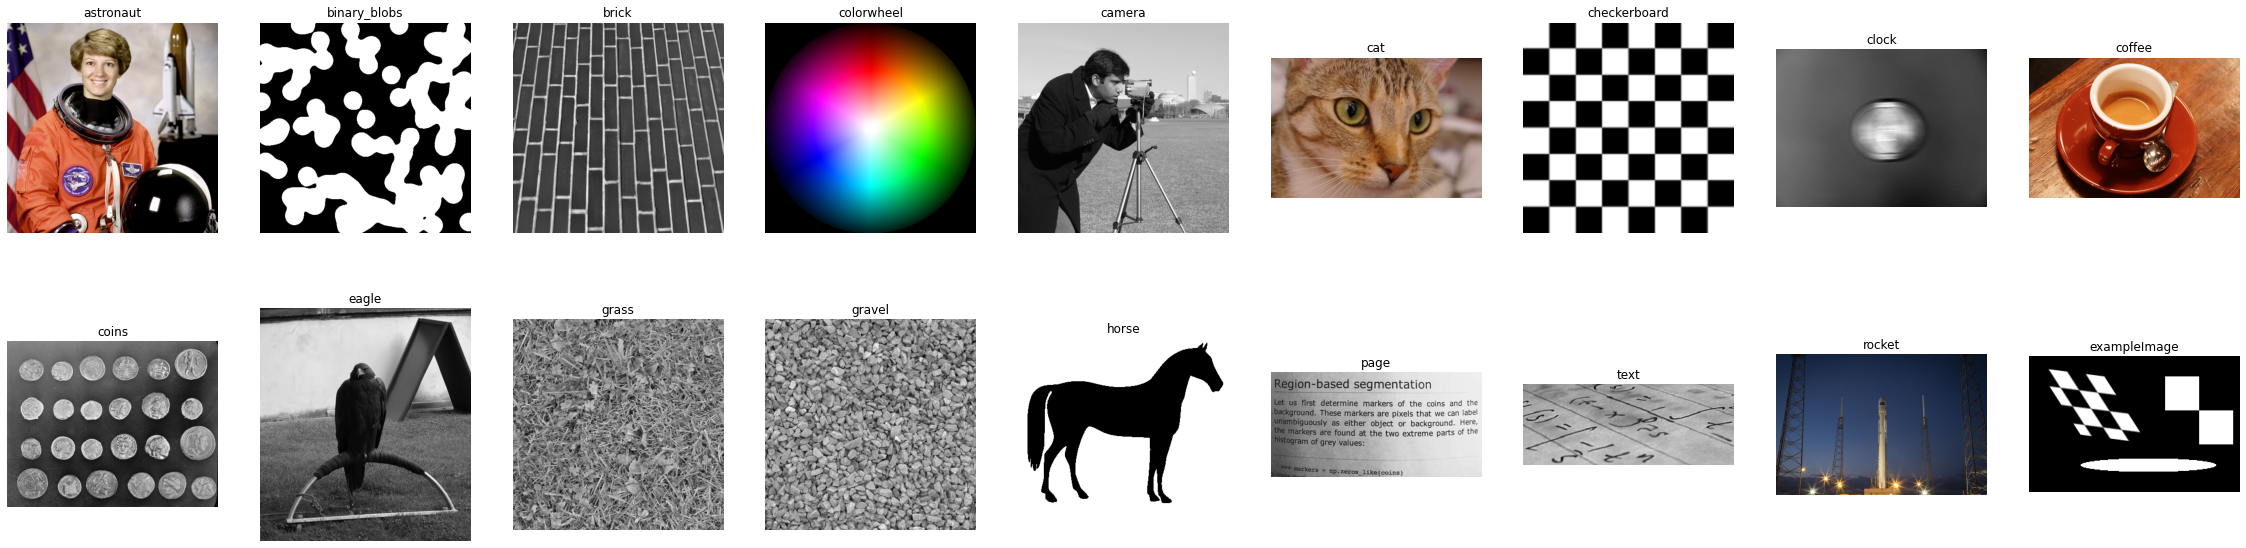

In [7]:
# plot all data images loaded in the previous cell
plotImages(images, grid=(2, int(len(images)/2)), figsize=(40, 10))
plt.show()

***
## Data processing

In [8]:
@interact(imageName=list(images.keys()), method=list(methods.keys()))
def harris(imageName='exampleImage', method='harris'):
    image = images[imageName]
    if image.ndim > 2:
        image = color.rgb2gray(image)

    coords = corner_peaks(methods[method](image), threshold_rel=0.02)
    coords_subpix = corner_subpix(image, coords, window_size=13)

    fig, ax = plt.subplots(figsize=(9, 9))
    ax.imshow(image, cmap=plt.cm.gray)
    ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o', linestyle='None', markersize=6)
    ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
    plt.show()


interactive(children=(Dropdown(description='imageName', index=17, options=('astronaut', 'binary_blobs', 'brick…

***

## Discussion

### Fast

<img style="float: right;" src="images/bresenham_circle.jpg">

Fast corner detection is based on the Bresenham circle of radius 3, which is formed by the 16 pixels that form a "circle" around each pixel. To select if a pixel is a corner, n pixels out of 16 must be all brighter or all darker than the intensity of the candidate pixel plus minus a threshold. To make the algorithm fast, the 4 orthogonal pixels \[1, 5, 9, 13\] are checked first. The candidate pixel is automatically discarded as a valid corner if 3 of the 4 pixels do not satisfy the previous condition. To observe the advantages and disadvantages we will evaluate the algorithm performance:

- **colorwheel** shows the robustness to gradual changes that fast algorithm has with respect to harris. Becuase of it's search on a significant change in the surroundings of the pixel and the use of a threshold, it is very robust to those changes.
- **text** compared to harris, fast algorithm is way less robust to corners that are a little bit rounded. It is able to detect some of the corners where the traces that intersect are thin, but it's unable to find the ones created by thicker traces.
- **checkerboard** shows a case where fast is not a good corner detector. The points are not detected because, even though 12 of the 16 points have an intensity difference over the threshold with the candidate pixels, the instensity comparison with pixels 1 5 9 and 13 discard automatically the pixels that should be detected as corners as it's shown in the next image, where the red crosses are the bresenham circle and the center of the circle is the candidate point. 

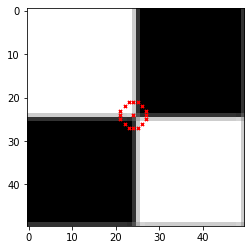

In [33]:
cir = np.concatenate((bresenham_circle(c=[24,24]), [[24, 24]]))
plt.imshow(images['checkerboard'][:50, :50], cmap='gray')
plt.scatter(cir[:,0], cir[:,1], s=10, marker='x', color='r')
plt.show()

### Harris

Harris corner detector is based on the detection of corners by the comparison of eigenvalues of the correlation matrix extracted from the convolution with DoG filters on the image. Those eigenvalues represent the gradient weights in the two most prominent directions at a given pixe. If the eigenvalues of the correlation matrix are similar and significantly big, the point is classified as a corner, as it has a brighness change in two directions. We will be comparing multiple images:

- **exampleImages** and **checkerboard** images are the most indicative of this method's strong points as they are specially designed to showcase the strengths of the algorithm, as they are maximum brighness changes in two directions that will constitute the corner detection
- **text** works nicely as well, ignoring the majority of the edges (the traces of the pen) and detecting almost all of the ends and the intersections between traces, which constitutes most of the corners in the image.
- **grass** shows a disadvantage of the detector, textures. Textures specially ones with a high multi-directional variance (not like wood, where the grains of the wood match a direction). Because of the nature of the harris corner detector, multidirectional change is not correctly detected by it.

***
## References
We report here relevant references:

1. The scikit-image corner detection example, https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_corner.html#sphx-glr-auto-examples-features-detection-plot-corner-py
2. Corner detectors in the scikit image package, https://scikit-image.org/docs/stable/api/skimage.feature.html
3. General purpose images of scikit-image, https://scikit-image.org/docs/stable/auto_examples/data/plot_general.html
4. Viswanathan, Deepak. “Features from Accelerated Segment Test ( FAST ).” (2011).
5. Derpanis, K. G. (2004). The harris corner detector. York University, 2.